# Import Packages

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import json

from constants import PRODUCT_TEST_EMBEDDINGS_PATH, CLASS_EMBEDDINGS_PATH, RANDOM_STATE, DEVICE, CLEANED_GPC_PATH, CLEANED_TEST_DATA_PATH

In [ ]:
product_df = pd.read_csv(CLEANED_TEST_DATA_PATH)
class_df = pd.read_csv(CLEANED_GPC_PATH)
product_embedding_df = pd.read_csv(PRODUCT_TEST_EMBEDDINGS_PATH)
class_embedding_df = pd.read_csv(CLASS_EMBEDDINGS_PATH)

In [3]:
# Merge names with embeddings
product_full = product_embedding_df.merge(product_df, on="id")
class_full = class_embedding_df.merge(class_df, on="id")

In [4]:
products_embeddings = [json.loads(embedding) for embedding in product_full["embeddings"].tolist()]
products_embeddings = torch.tensor(products_embeddings, dtype=torch.float16, device=DEVICE)

classes_embeddings = [json.loads(embedding) for embedding in class_full["embeddings"].tolist()]
classes_embeddings = torch.tensor(classes_embeddings, dtype=torch.float16, device=DEVICE)

In [5]:
products_embeddings = np.array(products_embeddings.cpu())
classes_embeddings = np.array(classes_embeddings.cpu())

C:\Users\ss255385\AppData\Local\Temp\ipykernel_23312\2825699126.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  products_embeddings = np.array(products_embeddings.cpu())
C:\Users\ss255385\AppData\Local\Temp\ipykernel_23312\2825699126.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  classes_embeddings = np.array(classes_embeddings.cpu())


In [ ]:
K = [1] + list(range(3, 80, 3))
np.random.seed(RANDOM_STATE)

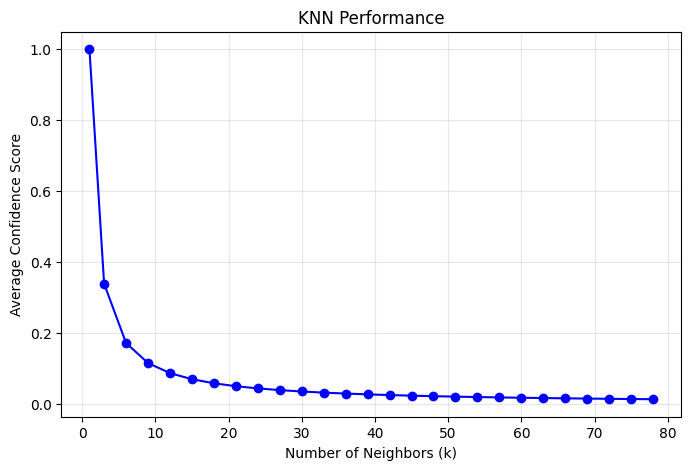

In [ ]:
avg_confidences = []

for k in K:
    knn = NearestNeighbors(n_neighbors=k, metric='cosine', algorithm='brute')
    knn.fit(classes_embeddings)
    distances, indices = knn.kneighbors(products_embeddings)

    confidences = []
    for dist in distances:
        weights = 1 / (dist + 1e-8)
        confidences.append(weights.max() / weights.sum())

    avg_confidences.append(np.mean(confidences))

plt.figure(figsize=(8,5))
plt.plot(K, avg_confidences, 'bo-')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average Confidence Score')
plt.title('KNN Performance')
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
knn = NearestNeighbors(n_neighbors= 3, metric='cosine', algorithm='brute')
knn.fit(classes_embeddings)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=3)

In [9]:
_, indices = knn.kneighbors(products_embeddings)

In [10]:
pred_classes = [Counter(idx).most_common(1)[0][0] for idx in indices]
confidences = [Counter(idx).most_common(1)[0][1] / len(idx) for idx in indices]
pred_class_names = [class_full["class_name"].iloc[i] for i in pred_classes]

In [11]:
product_full["predicted_class_name"] = pred_class_names
product_full["prediction_confidence"] = confidences

In [12]:
product_full.head()

,id,embeddings,Item_Name,Brand,cleaned_text,predicted_class_name,prediction_confidence
0,0,"[0.00963592529296875, 0.02484130859375, 0.0007...",americana okra zero 400 gm,americana,okra zero gm,food beverage vegetables (non leaf) unprepared...,0.333333
1,1,"[-0.0043792724609375, 0.033721923828125, 0.010...",ليمون اداليا 500 جم,NaN,ليمون اداليا جم,food beverage fruits unprepared unprocessed (f...,0.333333
2,2,"[0.00830078125, 0.025146484375, 0.001077651977...",صلصه هاينز برطمان خصم عرض,هاينز,صلصه برطمان خصم عرض,food beverage vegetables (non leaf) unprepared...,0.333333
3,3,"[0.03204345703125, 0.03460693359375, -0.001510...",dasani water 330ml,dasani,water ml,plumbing heating ventilation air conditioning ...,0.333333
4,4,"[0.034515380859375, 0.0298919677734375, 0.0040...",بودرة عصير أناناس من سورس، 900 جم,سورس,بودرة عصير أناناس من جم,food beverage vegetables (non leaf) unprepared...,0.333333
